# US Dept of Education - College Scorecard

## Objective
How does the average earning of graduates differ by the type of college? (Private-profit, private-non-profit, public)


# Libraries and modules imported

In [70]:
import pandas as pd
import numpy as np
import sqlite3 
import math
import matplotlib.pyplot as plt
import sklearn
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

# Extracting data from the database file

The database file and the College Scorecard.csv are the same, we will be using the database file to extract features that will be useful in our data analysis.

In [54]:
con = sqlite3.connect('output/database.sqlite')
data = pd.read_sql('SELECT UNITID, INSTNM, cast(SAT_AVG as int)SAT_AVG, cast(ACTENMID as int)ACTENMID, cast(ACTMTMID as int)ACTMTMID,\
                  cast(ACTWRMID as int)ACTWRMID, cast(TUITIONFEE_PROG as int)TUITIONFEE_PROG, cast(MD_EARN_WNE_P10 as int)MD_EARN_WNE_P10,\
                  cast(UNEMP_RATE as int) UNEMP_RATE, cast(MD_EARN_WNE_P6 as int)MD_EARN_WNE_P6, cast(ADM_RATE as int) ADM_RATE,\
                  cast(TUITIONFEE_IN as int) TUITIONFEE_IN,cast(TUITIONFEE_OUT as int) TUITIONFEE_OUT, CONTROL,STABBR from Scorecard', con)
df_copy = data.copy()
df = data.copy()

# Exploratory data analysis
Before jumping into data analysis, we must first have a thorough understanding of our data. <br>
First, we take a look at a brief summary of our data.

In [65]:
df.head(3)

,UNITID,INSTNM,SAT_AVG,ACTENMID,ACTMTMID,ACTWRMID,TUITIONFEE_PROG,MD_EARN_WNE_P10,UNEMP_RATE,MD_EARN_WNE_P6,ADM_RATE,TUITIONFEE_IN,TUITIONFEE_OUT,CONTROL,STABBR
32917,100654,ALABAMA A & M UNIVERSITY,970.0,20.0,21.0,NaN,NaN,NaN,4.0,NaN,0.0,4664.0,5200.0,Public,AL
32918,100663,UNIVERSITY OF ALABAMA AT BIRMINGHAM,1030.0,22.0,21.0,NaN,NaN,NaN,3.0,NaN,0.0,3640.0,6610.0,Public,AL
32920,100706,UNIVERSITY OF ALABAMA IN HUNTSVILLE,1109.0,24.0,23.0,NaN,NaN,NaN,3.0,NaN,0.0,3536.0,7430.0,Public,AL


In [360]:
df.describe()

,UNITID,SAT_AVG,ACTENMID,ACTMTMID,ACTWRMID,TUITIONFEE_PROG,MD_EARN_WNE_P10,UNEMP_RATE,MD_EARN_WNE_P6,ADM_RATE,TUITIONFEE_IN,TUITIONFEE_OUT
count,18598.000000,18598.000000,13192.000000,13178.000000,1443.000000,61.000000,4291.000000,4200.000000,7235.000000,18586.000000,18477.000000,18477.000000
mean,185646.514303,1052.701043,22.337553,22.015025,10.200970,8812.262295,43080.400839,2.900238,35181.700069,0.011406,15856.340586,18929.040862
std,49495.016987,126.892749,3.509800,3.250898,14.846363,7426.826164,11763.156516,0.794899,9862.569305,0.107702,10266.878735,8370.491880
min,100654.000000,514.000000,2.000000,2.000000,0.000000,1000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,153126.000000,970.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,185828.000000,1035.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,215132.000000,1115.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,483124.000000,1599.000000,36.000000,35.000000,530.000000,24192.000000,125800.000000,9.000000,127300.000000,3.000000,63073.000000,63073.000000


By looking at the output of .describe(), we can make a few conclusion that.

A lot of features have missing values, this conclusion is drawn by looking at the _count_ output. <br>
Furthermore by looking at the min values of variables like MD_EARN_WNE_P6 and ADM_RATE, which is zero which are logically wrong. <br> <br>
By looking further into the data, we can see that a lot of our data are missing (Labeled NaN). 
Unfortunately, running the dropna() command on the dataframe results in loss of <b>all</b> data as each row has at least one or two missing values. Hence data cleaning will be performed individually when we want to use the data.

## Descriptive Statistics

For each of the numerical variables, a histogram will be plotted out to see the distribution of data as well as to identify any outliers present in the variable. For non-numerical variables, barplots will be used.

We take a look at the distribution of the data to better understand our data as well as to make conclusions on data. For instance, we can find out the similarities between the data or where most of the data converge as just looking at the mean value sometimes is not accurate enough since mean can be easily affected by outliers.

For each of the graph, a short description of the data is printed out (max value, min value, standard deviation et cetera), as well as the variance of the data.<br> Variance very close to zero means that most of the data are similiar, while high variance often mean that most data is distinct. Hence by taking the variance value into consideration, we can remove features that carry little information.

In [237]:
# Clean NaN values from the variable we want to check
def cleanVariable(variable_to_check):
    df_SAT = df.copy()
    #df_SAT = df_SAT[~np.isnan(df_SAT[variable_to_check])] #Remove NaN values
    df_SAT = df_SAT[df_SAT[variable_to_check]>0]
    return df_SAT

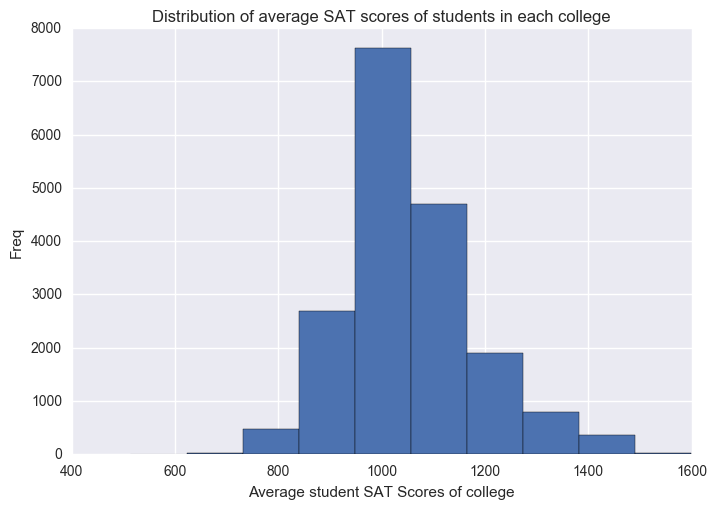

Variance:  16100.903957402055
count    18598.000000
mean      1052.701043
std        126.892749
min        514.000000
25%        970.000000
50%       1035.000000
75%       1115.000000
max       1599.000000
Name: SAT_AVG, dtype: float64


In [315]:
variable_to_check = "SAT_AVG"
dfplt = cleanVariable(variable_to_check)
plt.hist(dfplt[variable_to_check], bins=10)
plt.xlabel("Average student SAT Scores of college")
plt.ylabel("Freq")
plt.title("Distribution of average SAT scores of students in each college")
plt.show()

print("Variance: ", np.var(dfplt[variable_to_check])) 
print(dfplt[variable_to_check].describe())

From the histogram of the distribution of average SAT scores of students in college, we may conclude that if you have an overall SAT score of around 900~1200 you may be accepted to enroll in most college. However looking at the histogram, there are some university where the average SAT score of students enrolled are higher than average. We will take a look on those college later on.

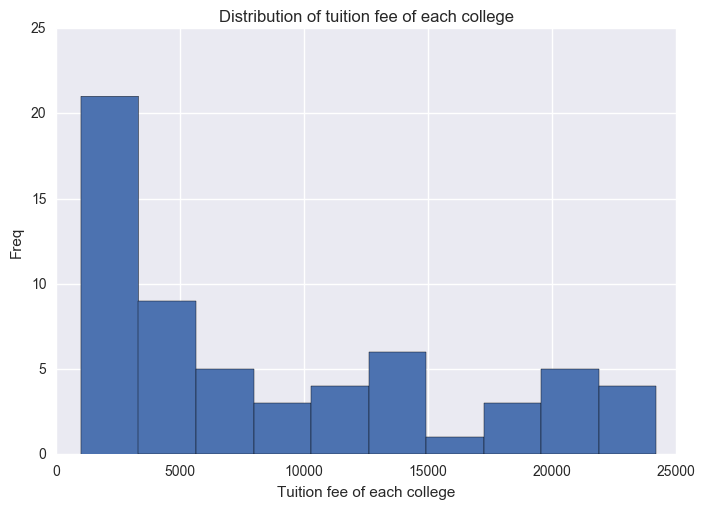

Variance:  54253521.50497178
count       61.000000
mean      8812.262295
std       7426.826164
min       1000.000000
25%       3000.000000
50%       6000.000000
75%      14250.000000
max      24192.000000
Name: TUITIONFEE_PROG, dtype: float64


In [309]:
variable_to_check = "TUITIONFEE_PROG"
dfplt = cleanVariable(variable_to_check)
plt.hist(dfplt[variable_to_check], bins=10)
plt.xlabel("Tuition fee of each college")
plt.ylabel("Freq")
plt.title("Distribution of tuition fee of each college")
plt.show()

print("Variance: ", np.var(dfplt[variable_to_check])) 
print(dfplt[variable_to_check].describe())

Looking in the histogram of distribution of tuition fee, we find that the tuition fee is relatively cheap for most college as the tuition fee for most colleges are below average the of $8812.

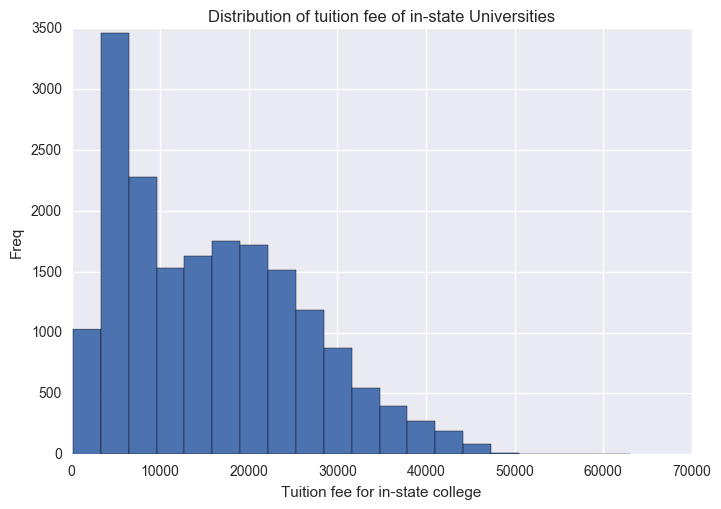

Variance:  105323949.35405278
count    18467.000000
mean     15864.926897
std      10263.023581
min        150.000000
25%       6536.000000
50%      14530.000000
75%      23010.000000
max      63073.000000
Name: TUITIONFEE_IN, dtype: float64


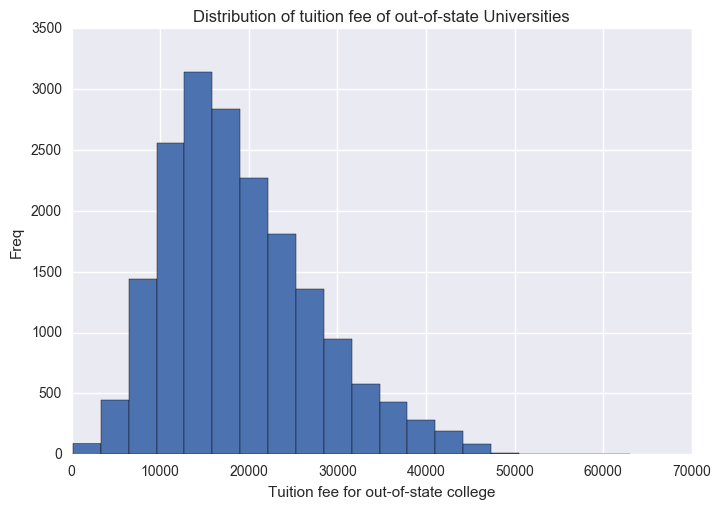

Variance:  69905149.47661003
count    18467.000000
mean     18939.291060
std       8361.156325
min        150.000000
25%      12828.000000
50%      17586.000000
75%      23915.500000
max      63073.000000
Name: TUITIONFEE_OUT, dtype: float64


In [308]:
variable_to_check = "TUITIONFEE_IN"
dfplt = cleanVariable(variable_to_check)
plt.hist(dfplt[variable_to_check], bins=20)
plt.xlabel("Tuition fee for in-state college")
plt.ylabel("Freq")
plt.title("Distribution of tuition fee of in-state Universities")
plt.show()
print("Variance: ", np.var(dfplt[variable_to_check])) 
print(dfplt[variable_to_check].describe())

variable_to_check = "TUITIONFEE_OUT"
dfplt = cleanVariable(variable_to_check)
plt.hist(dfplt[variable_to_check], bins=20)
plt.xlabel("Tuition fee for out-of-state college")
plt.ylabel("Freq")
plt.title("Distribution of tuition fee of out-of-state Universities")
plt.show()
print("Variance: ", np.var(dfplt[variable_to_check])) 
print(dfplt[variable_to_check].describe())

There are only slight difference in tuition fee for in-state and out-of-state college.
Furthermore, the histogram shows that there are some outliers for both of the variable. We will take a deeper look into the variable before removing the outlier.

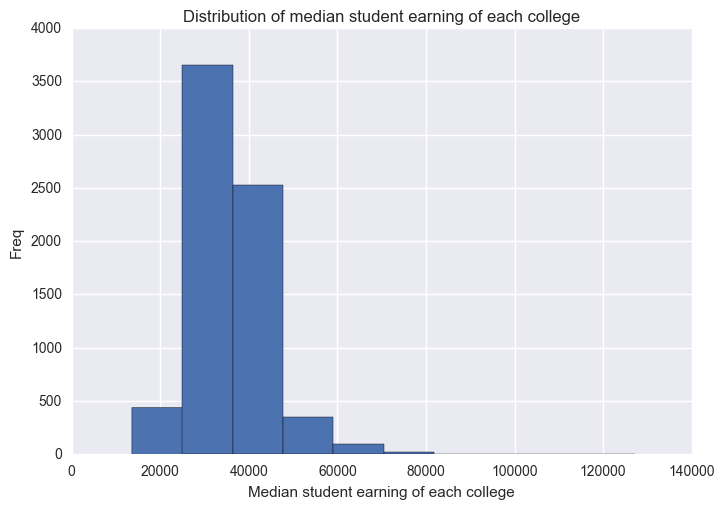

Variance:  74099423.58719297
count      7094.000000
mean      35880.969834
std        8608.708987
min       13600.000000
25%       30600.000000
50%       35000.000000
75%       39600.000000
max      127300.000000
Name: MD_EARN_WNE_P6, dtype: float64


In [307]:
variable_to_check = "MD_EARN_WNE_P6"
dfplt = cleanVariable(variable_to_check)
plt.hist(dfplt[variable_to_check], bins=10)
plt.xlabel("Median student earning of each college")
plt.ylabel("Freq")
plt.title("Distribution of median student earning of each college")
plt.show()

print("Variance: ", np.var(dfplt[variable_to_check])) 
print(dfplt[variable_to_check].describe())

We can say that most students' salary after they graduate falls around 30k-40k. However, there are obvious outliers shown where the maximum median earning of that college's graduate is $127300. We will look into it later to decide whether it is an error or not.

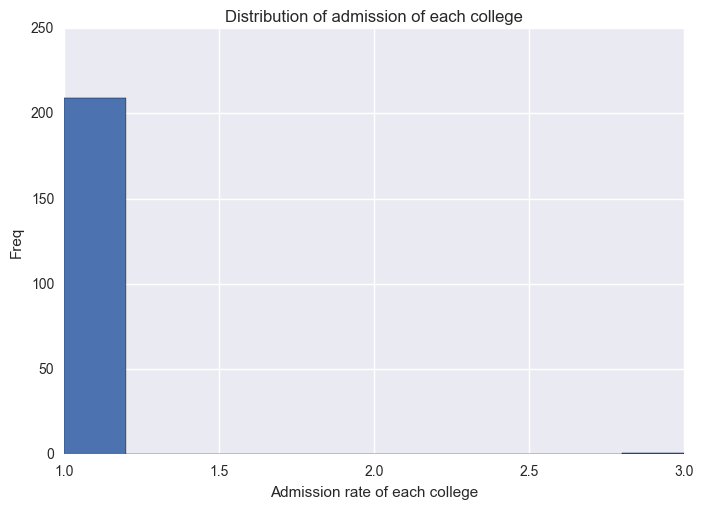

Rate of NaN:  98.8708463275621 %
Value count:
1.0    209
3.0      1
Name: ADM_RATE, dtype: int64
count    210.000000
mean       1.009524
std        0.138013
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        3.000000
Name: ADM_RATE, dtype: float64
Variance:  0.01895691609977329


In [316]:
variable_to_check = "ADM_RATE"
dfplt = cleanVariable(variable_to_check)
plt.hist(dfplt[variable_to_check])
plt.xlabel("Admission rate of each college")
plt.ylabel("Freq")
plt.title("Distribution of admission of each college")
plt.show()
print("Rate of NaN: ", (len(df)-len(dfplt))/len(df)*100, "%")
print("Value count:")
print(dfplt[variable_to_check].value_counts())
print(dfplt[variable_to_check].describe())
print("Variance: ", np.var(dfplt[variable_to_check])) 

Over 98% of data from ADM_RATE are NaN values, and the variance for the rest of the data is close to 0 which means majority of the data are the exact same. Hence we decided to drop this data, as it will not be useful in our analysis.

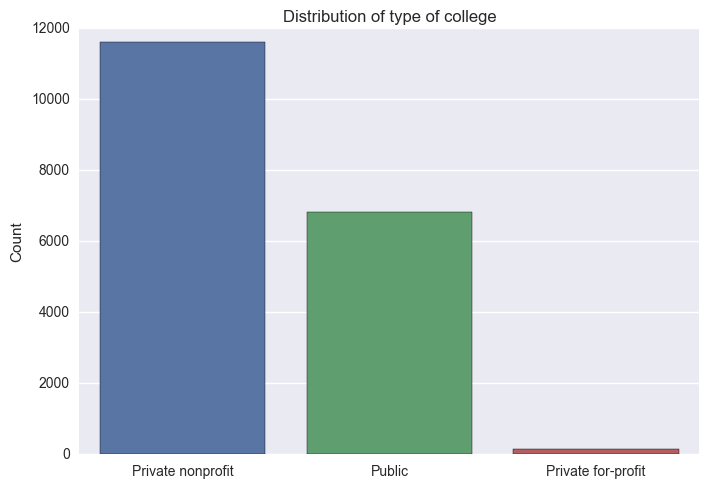

Private nonprofit     11615
Public                 6831
Private for-profit      152
Name: CONTROL, dtype: int64


In [359]:
variable_to_check = "CONTROL"
dfplt = df.copy()

sns.barplot( dfplt[variable_to_check].value_counts().index, dfplt[variable_to_check].value_counts() )
plt.ylabel("Count")
plt.title("Distribution of type of college")
plt.show()
print(dfplt[variable_to_check].value_counts())

From the distribution fo type of college, we can tell that most colleges in the US are private-nonprofit. While the minority are private for-profit.

In [ ]:
inout = df_copy.copy()
inout = inout[(inout.TUITIONFEE_IN > 0) & (inout.TUITIONFEE_OUT > 0)]
inout = inout[['TUITIONFEE_IN','TUITIONFEE_OUT','CONTROL']]
sns.regplot(inout.TUITIONFEE_IN,inout.TUITIONFEE_OUT,scatter=True,fit_reg=True)
plt.show()

In [ ]:
sns.lmplot(x="TUITIONFEE_IN",y="TUITIONFEE_OUT",col="CONTROL",data = inout,truncate=True)
plt.show()

In [ ]:
inout.groupby('CONTROL').mean()

In [ ]:
asd = df_copy.copy()
asd = asd[['INSTNM','STABBR']]
asd = asd.groupby('STABBR').count().sort_values('INSTNM')
asd

In [ ]:
asd = df_copy.copy()
asd = asd[asd['UNEMP_RATE']>0]
asd = asd[['INSTNM','STABBR','UNEMP_RATE',]]
asd = asd.sort_values('UNEMP_RATE',ascending=False)
asd.head(6)

In [ ]:
Sat_6yEarn = df_copy[(df_copy.SAT_AVG > 0) & (df_copy.MD_EARN_WNE_P6 > 0) ]
plt.scatter(Sat_6yEarn['SAT_AVG'], Sat_6yEarn['MD_EARN_WNE_P6'])
plt.xlabel('SAT_AVG')
plt.ylabel('MD_EARN_WNE_P6')
plt.title("Relationship  between Average SAT Score and Earning")
plt.show()

#clearly an increasing sign

In [ ]:
#find if Tuition fee affect Earning
Tui_6yEarn = df_copy[(df_copy.TUITIONFEE_PROG > 0) & (df_copy.MD_EARN_WNE_P6 > 0) ]
plt.scatter(Tui_6yEarn['TUITIONFEE_PROG'], Tui_6yEarn['MD_EARN_WNE_P6'])
plt.xlabel('Tuition Fee')
plt.ylabel('Earning')
plt.title("Relationship  between Tuition Fee and Earning")
plt.show()
#not quite, and hard to see as most of the tuition fee fall in the lower range

In [ ]:
Sat3_6yEarn = df_copy[(df_copy.ACTENMID > 0)  & (df_copy.ACTMTMID > 0) & (df_copy.ACTWRMID > 0) & (df_copy.MD_EARN_WNE_P6 > 0) ]
acs = Sat3_6yEarn.sort_values(['ACTENMID', 'ACTMTMID', 'ACTWRMID'], ascending = False).head(10)
des = Sat3_6yEarn.sort_values(['ACTENMID', 'ACTMTMID', 'ACTWRMID'], ascending = True).head(10)
top = plt.plot(acs['MD_EARN_WNE_P6'],'ro', label="Top10")
btn = plt.plot(des['MD_EARN_WNE_P6'],'bo', label="Worst10")  

plt.title("Top10 SAT score compare with Worst10 SAT score(Earning in 6 years)")
plt.legend()
plt.ylabel('Earning')
plt.show()
#red mean the top 10 SAT score in read, writing and english
#blue mean the least 10 SAT score in read, writing and english
#clearly we can know that red earn high than blue

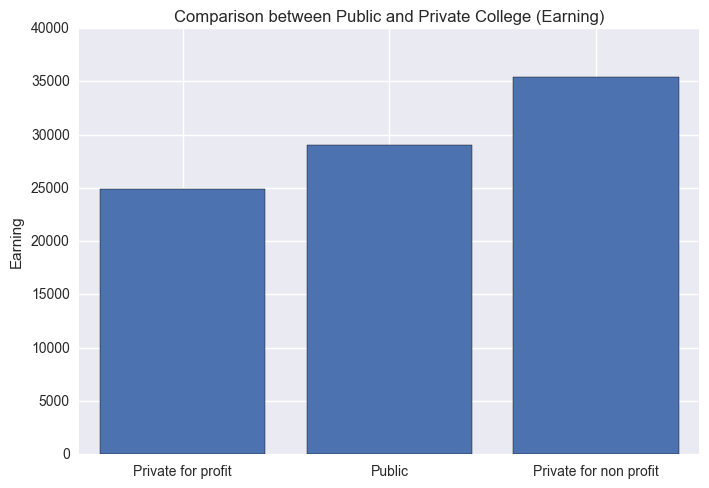

In [328]:
public = df_copy[(df_copy.CONTROL == 'Public')]
private_np = df_copy[(df_copy.CONTROL == 'Private nonprofit')]
private_p = df_copy[(df_copy.CONTROL == 'Private for-profit')]
public = public[public.MD_EARN_WNE_P6 > 0]
private_np = private_np[private_np.MD_EARN_WNE_P6 > 0]
private_p = private_p[private_p.MD_EARN_WNE_P6 > 0]
x = sum(public['MD_EARN_WNE_P6'])/len(public)
y = sum(private_np['MD_EARN_WNE_P6'])/len(private_np)
z = sum(private_p['MD_EARN_WNE_P6'])/len(private_p)
dictionary = plt.figure()

D = {u'Public':x, u'Private for non profit': y, u'Private for profit':z}

plt.title("Comparison between Public and Private College (Earning)")
plt.bar(range(len(D)), D.values(), align='center')
plt.xticks(range(len(D)), D.keys())
plt.ylabel('Earning')
plt.show()

In [ ]:
linear_data = df_copy.copy()
linear_data = linear_data[(linear_data.ACTENMID > 0)  & (linear_data.ACTMTMID > 0) & (linear_data.ACTWRMID > 0) & (linear_data['MD_EARN_WNE_P6']>0)]
linear_data = linear_data[['ACTENMID', 'ACTMTMID', 'ACTWRMID','MD_EARN_WNE_P6']]

from sklearn.linear_model import LinearRegression
x = linear_data.drop('MD_EARN_WNE_P6' , axis = 1)
lm = LinearRegression()
lm.fit(x,linear_data.MD_EARN_WNE_P6)

print ('Estimated intercept', len(lm.coef_))
a = pd.DataFrame(list(zip(x.columns, lm.coef_)), columns = ['f', 'est'])
print(a)
#since SAT math is the highest corelation, hence we plot SAT math

plt.scatter(linear_data.ACTMTMID, linear_data.MD_EARN_WNE_P6)
plt.xlabel("Math SAT score")
plt.ylabel("Earning in 6 years")
plt.title("Relationship between Math SAT score and Earning in 6 years (actual)")
plt.show()

In [ ]:
lm.predict(x)[0:328]
plt.scatter(linear_data.ACTMTMID, lm.predict(x))
plt.xlabel("Math SAT score")
plt.ylabel("Earning in 6 years")
plt.title("Relationship between Math SAT score and Earning in 6 years (predict)")
plt.show()

In [ ]:
import sklearn.cross_validation
x_train, x_test, y_train, y_test = sklearn.cross_validation.train_test_split(x, linear_data.MD_EARN_WNE_P6, test_size = 0.33, random_state = 5)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
lm = LinearRegression()
lm.fit(x_train, y_train)
pred_train = lm.predict(x_train)
pred_test = lm.predict(x_test)

In [ ]:
print("Train mean square error:", np.mean((y_train - lm.predict(x_train)) ** 2))
print("Test mean square error:", np.mean((y_test - lm.predict(x_test)) ** 2))

In [ ]:
plt.scatter(lm.predict(x_train),lm.predict(x_train) - y_train, c='b', s=40, alpha=0.5)
plt.scatter(lm.predict(x_test),lm.predict(x_test) - y_test, c='g', s=40)
plt.hlines(y = 0, xmin=0, xmax = 70000)
plt.title('Error Rate for Training and Testing Set')
plt.ylabel('Error Rate')
plt.show()

#most of it scatter around 0, good!

In [ ]:
from sklearn import linear_model
import numpy as np
lm = linear_model.LinearRegression()
lm.fit(x_train, y_train)
pred_test = lm.predict(x_test)
fit = np.polyfit(x['ACTMTMID'],linear_data.MD_EARN_WNE_P6,1)
p = np.poly1d(fit)
math = plt.plot(x['ACTMTMID'], linear_data.MD_EARN_WNE_P6, 'ro', label = "math")
writing = plt.plot(x['ACTWRMID'], linear_data.MD_EARN_WNE_P6, 'go', label = "writing")
english = plt.plot(x['ACTENMID'], linear_data.MD_EARN_WNE_P6, 'bo', label = "english")
plt.title("Relationship between SAT and Earning(actual)")
plt.xlabel("SAT")
plt.ylabel("Earning")
plt.legend()
plt.show()

In [ ]:
#since we know math has highest corelation, try to fit and compare using it
math = plt.plot(x['ACTMTMID'], linear_data.MD_EARN_WNE_P6, 'ro', label = "math")
xp = np.linspace(15, 35, 50)
best_fit = plt.plot(xp, p(xp), '-', color='green', label="best fit line")

plt.title("Relationship between SAT[Math] and Earning(actual)")
plt.xlabel("SAT[Math]")
plt.ylabel("Earning")
plt.legend()
plt.show()

In [ ]:
fit = np.polyfit(x_test['ACTMTMID'],lm.predict(x_test),1)
p = np.poly1d(fit)

plt.plot(x_test['ACTMTMID'], lm.predict(x_test), 'ro')
xp = np.linspace(15, 35, 50)
orange = plt.plot(xp, p(xp), '-')

plt.title("Relationship between SAT[Math] and Earning(model)")
plt.xlabel("SAT[MATH]")
plt.ylabel("Earning")
plt.show()

In [ ]:
print("Mean square error for the model is:", np.mean((y_test - lm.predict(x_test)) ** 2)) 
print("The estimated coeficient of English is: ", lm.coef_[0])
print("The estimated coeficient of Math is: ", lm.coef_[1])
print("The estimated coeficient of Writing is: ", lm.coef_[2])

In [ ]:
print(lm.predict([30,30,11]))

# Regression tree
## Question: Predicting income based on XXX.

Input: <br>
Class label: MD_EARN_WNE_P6

SAT Score , CONTROL, locale of institute, 


In [ ]:
#Preparing the data
income = df_copy.copy()
income = income[ (income["MD_EARN_WNE_P6"] > 0) & (income["ACTMTMID"] > 0) & (income.ACTMTMID > 0) & (income.ACTWRMID > 0)]
income["CONTROL_NUM"] = income["CONTROL"].astype("category")
income["CONTROL_NUM"] = income["CONTROL_NUM"].cat.rename_categories([1,2,3])

from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
ind = np.random.rand(len(income)) < 0.8
trainingSet = income[ind]
testingSet = income[~ind]

X = np.sort(np.array(trainingSet[["ACTMTMID"]]))
y = np.sort(trainingSet["MD_EARN_WNE_P6"].values)
rt = DecisionTreeRegressor(max_depth=500)

testPredictor = np.array(testingSet[["ACTMTMID"]])
rt.fit(X,y)
pred =  rt.predict(testPredictor)
testClass = testingSet["MD_EARN_WNE_P6"].values

'''
plt.figure()
plt.plot(X, y, 'ro', label="data")
plt.plot(testPredictor,pred, color="cornflowerblue", label="Test", linewidth=2)
plt.show()
'''
print (testClass)
print("Test mean square error:", np.mean((testClass - pred) ** 2))

In [ ]:
#Preparing the data
income = df_copy.copy()
income = income[ (income["MD_EARN_WNE_P6"] > 0) & (income["ACTMTMID"] > 0) & (income.ACTMTMID > 0) & (income.ACTWRMID > 0)]
income["INCOME_RANGE"] = pd.cut(income["MD_EARN_WNE_P6"], bins=2, labels=["Low","High"])
income["CONTROL_NUM"] = income["CONTROL"].astype("category")
income["CONTROL_NUM"] = income["CONTROL_NUM"].cat.rename_categories([1,2,3])

from sklearn import tree
ind = np.random.rand(len(income)) < 0.7
trainingSet = income[ind]
testingSet = income[~ind]

X = trainingSet[["ACTMTMID","ACTWRMID","ACTWRMID","CONTROL_NUM"]]
Y = trainingSet["INCOME_RANGE"]

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)

actual = testingSet["INCOME_RANGE"]
pred = clf.predict(testingSet[["ACTMTMID","ACTWRMID","ACTWRMID","CONTROL_NUM"]])

pd.crosstab(actual, pred, rownames=["Actual"], colnames=["Predicted"])

In [ ]:
income["TUITIONFEE_PROG"].dropna()